In [8]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline
import GraphHelpers as GH

Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28

In [6]:
AlbedoDF = pd.read_pickle('.\DataFrames\DailyAlbedoCor.pkl')
EstAlbedoDF = pd.read_pickle('.\DataFrames\DailyAlbedoCorEstInt.pkl')
TnRData = pd.read_pickle('.\DataFrames\TempAndMet.pkl')
TnRHourlyMeans = TnRData.resample('H').mean()
TnRHourlyMeans.sort_index(axis=1,inplace=True)
TnRHourlySums = TnRData.resample('H').sum()
TnRHourlySums.sort_index(axis=1,inplace=True)
AlbedoHourly = EstAlbedoDF.resample('H').ffill().reindex(TnRHourlyMeans.index)
AlbedoHourly.sort_index(axis=1,inplace=True)
EstAlbedoHourly = EstAlbedoDF.resample('H').ffill().reindex(TnRHourlyMeans.index)
EstAlbedoHourly.sort_index(axis=1,inplace=True)

In [13]:
GPs = GH.SetGraphicsPatterns(TnRData.IR_SurfaceTemp.columns,
                    ['--','-'],
                    [0.15,0.45],
                    ['o','^'],
                    ['blue','red','green'])

Cultivar
['Dash', 'Omaka']
Irrigation
['High', 'Low', 'Mid']
Treatments
MultiIndex(levels=[['Dash', 'Omaka'], ['High', 'Low', 'Mid']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('--', 'blue', 0.15, 'o'), ('--', 'red', 0.15, 'o'), ('--', 'green', 0.15, 'o'), ('-', 'blue', 0.45, '^'), ('-', 'red', 0.45, '^'), ('-', 'green', 0.45, '^')]
StyleFrame
           Lin    Col   Alp Mar    MFC
Dash  High  --   blue  0.15   o   blue
      Low   --    red  0.15   o    red
      Mid   --  green  0.15   o  green
Omaka High   -   blue  0.45   ^  white
      Low    -    red  0.45   ^  white
      Mid    -  green  0.45   ^  white


## Set up dataframe for net radiation measured on detailed heat balance plots

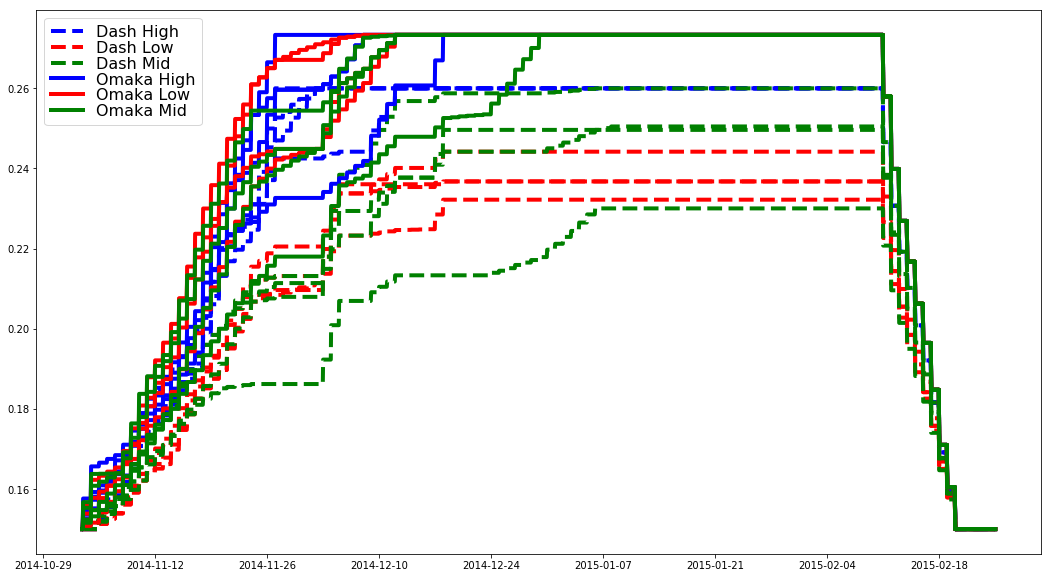

In [14]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(AlbedoHourly,ax,GPs,4)
GH.AddLegend(2,16,"")

In [15]:
DetailSubSet = [('Dash','High','1'),('Dash','High','3'),('Dash','High','4'),
          ('Dash','Low','1'),('Dash','Low','3'),('Dash','Low','4'),
          ('Omaka','High','1'),('Omaka','High','3'),('Omaka','High','4'),
          ('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','4')]
DetailColumnIndex = pd.MultiIndex.from_tuples(DetailSubSet,
                                       names=['Cultivar','Irrigation','Block'])

In [16]:
RnDF = pd.DataFrame(index=TnRHourlyMeans.index,columns=DetailColumnIndex,)
RnDF.sort_index(axis=0, inplace=True)
RnDF.sort_index(axis=1, inplace=True)
for plot in RnDF.columns:
    RnDF.loc[:,plot] = [et.NetRadiation(TnRHourlySums.loc[x,'IncomingRadnMJ'].values[0],
                              TnRHourlyMeans.loc[x,'AirTemperature'].values[0],
                              TnRHourlyMeans.loc[x,'VP'].values[0],
                              Lattitude,
                              x.dayofyear,
                              TnRHourlyMeans.loc[x,'Duration'].values[0],
                              TnRHourlyMeans.loc[x,'Time'].values[0],
                              LongitudeTZ,
                              LongitudeML,
                              AlbedoHourly.loc[x,plot]) for x in RnDF.index]  

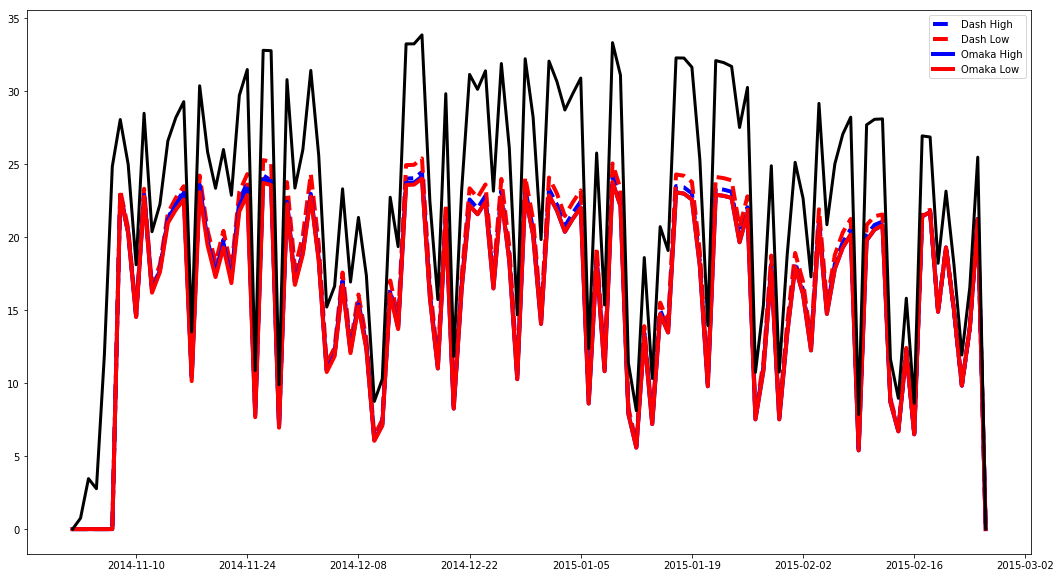

In [17]:
RnDaily = RnDF.resample('D').sum().groupby(level=('Cultivar','Irrigation'),axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(RnDaily,ax,GPs,4)
plt.plot(TnRHourlySums.loc[:,'IncomingRadnMJ'].resample('D').sum(),color='k',linewidth=3)
plt.legend()

## Convert radiation to W/m2

In [18]:
RnDF.index.name='Date'
RnDFLong = RnDF.unstack()
RnDFLong.name='Rn'
RnDFLong.to_pickle('.\DataFrames/NetRadiationMJ.pkl')
RnDFLong = RnDFLong * 1000000 / (60 * 60)

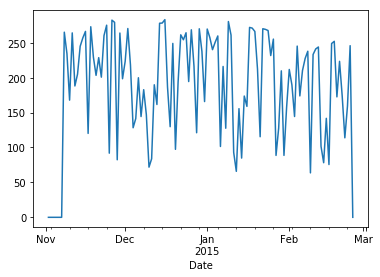

In [19]:
RnDFLong.loc[('Dash','High','1')].resample('D').mean().plot()

In [20]:
RnDFLong.name = 'Rn'

In [21]:
RnDFLong.to_pickle('.\DataFrames/NetRadiation.pkl')

## Set up data frame for net Radiation estimated for all plots

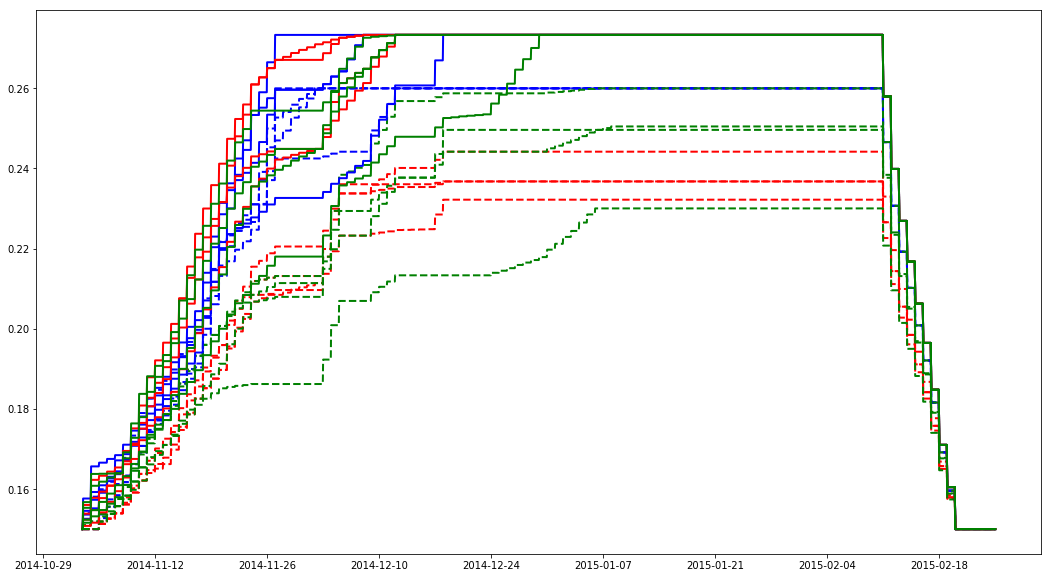

In [22]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(EstAlbedoHourly,ax,GPs,2)

In [23]:
FullColumnIndex = pd.MultiIndex.from_product([['Dash','Omaka'],
                                       ['High','Low','Mid'],
                                       ['1','2','3','4']],
                                       names=['Cultivar','Irrigation','Block'])

In [24]:
EstRnDF = pd.DataFrame(index=TnRHourlyMeans.index,columns=FullColumnIndex)
for plot in EstRnDF.columns:
    EstRnDF.loc[:,plot] = [et.NetRadiation(TnRHourlySums.loc[x,'IncomingRadnMJ'].values[0],
                              TnRHourlyMeans.loc[x,'AirTemperature'].values[0],
                              TnRHourlyMeans.loc[x,'VP'].values[0],
                              Lattitude,
                              x.dayofyear,
                              TnRHourlyMeans.loc[x,'Duration'].values[0],
                              TnRHourlyMeans.loc[x,'Time'].values[0],
                              LongitudeTZ,
                              LongitudeML,
                              EstAlbedoHourly.loc[x,plot]) for x in RnDF.index]  

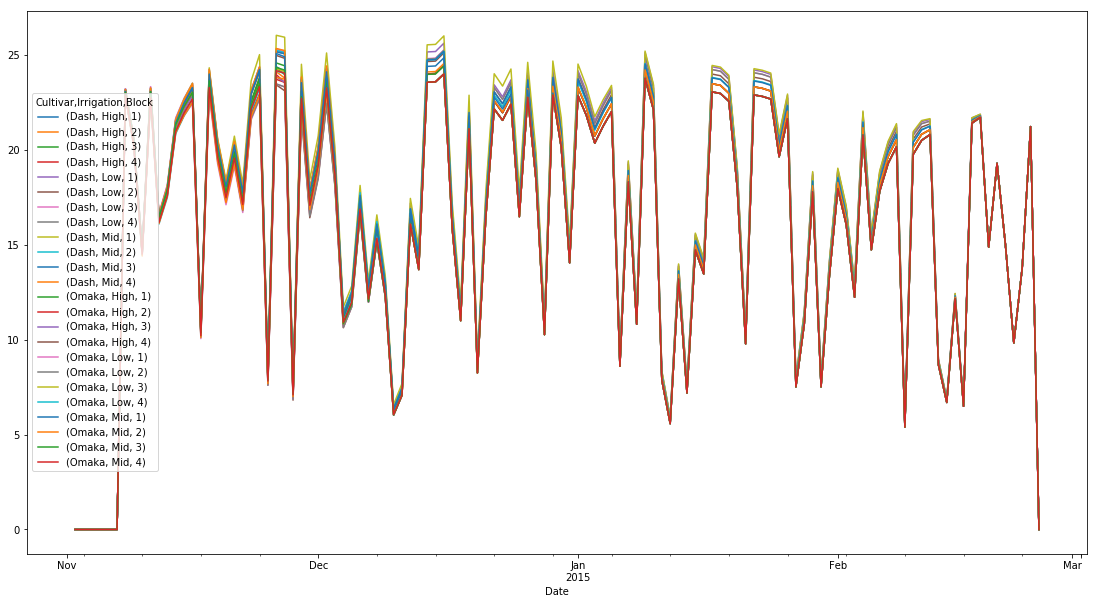

In [25]:
EstRnDF.resample('D').sum().plot(figsize=(19,10))

## Make Long

In [26]:
EstRnDF.index.name='Date'
EstRnDFDaily = EstRnDF.resample('D').sum()
EstRnDFLong = EstRnDFDaily.unstack()
EstRnDFLong = EstRnDFLong

In [27]:
EstRnDFLong.to_pickle('.\DataFrames\EstNetRadiation.pkl')
EstRnDF.resample('d').sum().to_pickle('.\DataFrames\DailyRn.pkl')